# ネットワーク解析のガイド (パート 3 - 到達圏の作成)

## 目次

- [イントロダクション](#イントロダクション)
- [データ](#データ)
    - [施設レイヤーの定義](#施設レイヤーの定義)
- [メソッド](#メソッド)
    - [メソッド 1 - arcgis.network.analysis.generate_service_areas を使う](#メソッド-1---arcgis.network.analysis.generate_service_areas-を使う)
        - [generate_service_areas の結果をテーブル化する](#generate_service_areas-の結果をテーブル化する)
        - [generate_service_areas の結果を可視化する](#generate_service_areas-の結果を可視化する)
        - [異なる時刻で到達圏を作成する](#異なる時刻で到達圏を作成する)
    - [メソッド 2 - arcgis.features.use_proximity.create_drive_time_areas を使う](#メソッド-2---arcgis.features.use_proximity.create_drive_time_areas-を使う)
        - [output_name を指定する場合](#output_name-を指定する場合)
        - [output_name を指定しない場合](#output_name-を指定しない場合)
- [次のトピックについて](#次のトピックについて)
- [参考](#参考)

## イントロダクション
私達はネットワーク データセット、ネットワーク解析サービス、そして、どのようにしてある点から別の地点へのルート解析や多数の地点間でのルート解析を行うかについて学びました。3 つ目のトピック、つまり、どのようにして到達圏解析を行うのか、に移りましょう。

前回のトピックを再確認したい場合や、次のトピックにスキップしたい場合は以下のロード マップを参照してください。

- ネットワーク データセットとネットワーク解析サービス (<a href="part1_introduction_to_network_analysis.ipynb">Part 1</a>)
- ルートの検索 (<a href="part2_find_routes_ja.ipynb">Part 2</a>)
- 到達圏の生成 (今ここ！)
- 最寄り施設の検出 (<a href="part4_find_closest_facilities.ipynb">Part 4</a>)
- OD コスト マトリックスの生成 (<a href="part5_generate_od_cost_matrix.ipynb">Part 5</a>)
- ロケーション-アロケーションの解析 (<a href="part6_solve_location_allocation.ipynb">Part 6</a>)
- 配車ルート (VRP) の解析 (<a href="part7_vehicle_routing_problem.ipynb">Part 7</a>)

このパートは、あるフィーチャに設定した距離の範囲内で何が起きているのかや、移動範囲内で何が起こっているか（距離、時間、またはコストを使用して測定）を見つけ出し、これらの利点をもたらすのに役立ちます。[[1]](#参考)

- **あるイベントや活動により影響をうける地域 (そしてその地域内のフィーチャ) を特定することができる**。例えば、都市計画担当者は、酒屋の出店が計画されている場合、500 フィート以内の住民に事前に通知する必要があります。
- **地域内の活動をモニタリングできる**。例えば、州の森林管理部門のスタッフが、河川から 100 メートル以内で禁止されている伐採をモニタリングすることができます。
- **ある施設のサービス提供範囲を明確にすることができる**。例えば、消防署長が消防署から車で 3 分以内の建物を把握したい時や、小売店の出店に適した場所を調査している GIS アナリストが出店計画中の場所から車で 15 分以内の地域にどれだけの人が住んでいるかを知りたい場合に活用できます。
- **特定の用途に適した地域を可視化できる**。生物学者を例にしましょう。シカの主要な生息地を把握すために、生物学者が河川から 0.5 マイル以内の地域を、植生、傾斜、その他の要因と組み合わせて把握することができます。

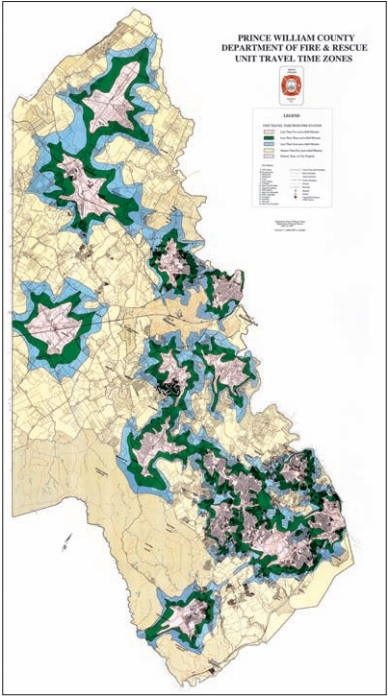

図1. バージニア州プリンス ウィリアム郡の消防・救命局は、新しい消防署をどこに設置するかを決めるために、既存の消防署から 5 分、10 分、15 分以内の地域を地図上に可視化している。出典: [[1]](#参考)

何が近くにあるかを把握するための最初のステップは、「近さ」をどのように計測するかを決めることです。近さは、直線距離、ネットワーク上の距離またはコスト、もしくはサーフェス上のコストで計測することができます[[1]](#参考)。

- 直線距離で近さを定義した場合、ソース フィーチャと距離を指定する必要があります。すると、ArcGIS API for Python はそのエリアや範囲内にあるフィーチャを見つけ出してくれます。このアプローチは、境界を作成したり、ソース フィーチャから設定された距離にあるフィーチャを選択する場合に良い方法です (図 2 左側)。
- ネットワーク上の距離またはコストで近さを定義した場合、ソースとなる場所と各ライン フィーチャに沿った距離 (もしくは移動コスト) を指定する必要があります。すると、API が距離 / コスト内にあるネットワークを見つけ出します。このアプローチは、固定されたネットワーク上におけるある場所からの移動距離またはコスト内に何があるかを見つけ出す場合に良い方法です (図 2 中央)。
- サーフェス上のコストで近さを定義した場合、ソース フィーチャの位置と、移動コストを指定する必要があります。API はソース フィーチャからの移動コストを示す新しいレイヤーを作成します。このアプローチは陸上の移動コストを算出する際に優れています (図 2 右側)。

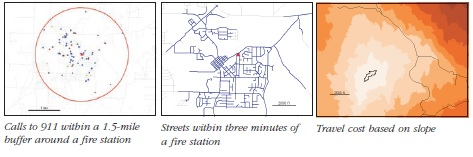
図 2. (左) 直線距離によってバッファーを作成; (中央) ネットワーク上の距離またはコストを算出; (右) 傾斜に基づいたソースから目的地までの移動コスト マップ。

出典: [[1]](#参考).

`到達圏` はアクセスできる範囲を可視化・計測するために広く用いられています。例えば、食料品店から運転時間 3 分以内を表すポリゴンは、どの住民が 3 分以内で店舗にたどり着けるかを明確にし、その店で買い物をする可能性が高いかどうかを判断することができます [[2]](#参考)。到達圏はアクセスのしやすさを評価することにも役立ちます。同心円状の到達圏はアクセスのしやすさがどのように異なるかを示します。到達圏が作成されたら、近隣地域の中にどれだけの土地、人口、その他のものが含まれているかを特定することが出来ます。到達圏解析のツールは、特定の時間または距離制限の中で、車両がどのくらいの距離を移動できるかを調べる機能を提供します。


いま、私達は到達圏の作成がなぜ必要なのかと、近さを測定することの基本を学びました。次はコードを実際に動かしてみましょう！

## データ
一番最初のステップは、常に、必要なモジュールを読み込んで、GIS オブジェクトを ArcGIS Online の組織等に接続することです。

もし、ArcGIS Onlineの組織に対して既にプロファイルを設定 (訳注：認証情報をローカルのコンピューターに保存しておくことができます。詳細は[認証に係るガイド](https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/#Storing-your-credentials-locally)を参照ください) していれば以下のセルを実行してプロファイルをロードして GIS クラスのオブジェクトを作成してください。もし設定していなければ、ユーザー名、パスワードを用いてログインしてください。例：`my_gis = GIS('https://www.arcgis.com', 'arcgis_python', 'P@ssword123', verify_cert=False, set_active=True)`

In [1]:
from arcgis.gis import GIS
import arcgis.network as network
from arcgis.features import FeatureLayer, Feature, FeatureSet, use_proximity
import pandas as pd
import datetime as dt
import time

In [4]:
my_gis = GIS(profile="your_online_profile")

Profile your_online_profile does not have a password on file through keyring. If you are expecting this behavior (PKI or IWA authentication, entering password through run-time prompt, etc.), please ignore this message. If you would like to store your password in the your_online_profile profile, run GIS(profile = 'your_online_profile', password = ...). See the API doc for more details. (http://bit.ly/2CK2wG8)


### 施設レイヤーの定義
もし次のセルで参照している `Esri LivingAtlas` が提供している病院のレイヤーにアクセス出来ない場合は、この [URL](https://data.chhs.ca.gov/datastore/dump/641c5557-7d65-4379-8fea-6b7dedbda40b?q=&sort=_id+asc&fields=OSHPD_ID%2CFACILITY_NAME%2CLICENSE_NUM%2CFACILITY_LEVEL_DESC%2CDBA_ADDRESS1%2CDBA_CITY%2CDBA_ZIP_CODE%2CCOUNTY_CODE%2CCOUNTY_NAME%2CER_SERVICE_LEVEL_DESC%2CTOTAL_NUMBER_BEDS%2CFACILITY_STATUS_DESC%2CFACILITY_STATUS_DATE%2CLICENSE_TYPE_DESC%2CLICENSE_CATEGORY_DESC%2CLATITUDE%2CLONGITUDE&filters=%7B%22COUNTY_CODE%22%3A+%5B%2236%22%5D%7D&format=csv) からサンバーナーディーノ郡の病院のリストをダウンロードし、csv ファイルを組織に公開してください。

In [5]:
""" この try-except ブロックは、あなたがレイヤーへのアクセスや操作の権限を持っていな買った場合に、CSV のダウンロードと公開を助けてくれます。
"""
try:
    hospital_item = my_gis.content.get("a2817bf9632a43f5ad1c6b0c153b0fab")
except Exception as ne:
    try:
        print("Trying from an alternative source...")
        hospital_item = my_gis.content.get("50fb63f303304835a048d16bd86c3024")
    except Exception as ne:
        print("Trying to publish from csv...")
        import requests
        import csv
        import os

        out_file_name = 'hospitals_SB_county.csv'
        url = "https://data.chhs.ca.gov/datastore/dump/641c5557-7d65-4379-8fea-6b7dedbda40b?q=&sort=_id+asc&fields=OSHPD_ID%2CFACILITY_NAME%2CLICENSE_NUM%2CFACILITY_LEVEL_DESC%2CDBA_ADDRESS1%2CDBA_CITY%2CDBA_ZIP_CODE%2CCOUNTY_CODE%2CCOUNTY_NAME%2CER_SERVICE_LEVEL_DESC%2CTOTAL_NUMBER_BEDS%2CFACILITY_STATUS_DESC%2CFACILITY_STATUS_DATE%2CLICENSE_TYPE_DESC%2CLICENSE_CATEGORY_DESC%2CLATITUDE%2CLONGITUDE&filters=%7B%22COUNTY_CODE%22%3A+%5B%2236%22%5D%7D&format=csv"
        download = requests.get(url)

        with open(out_file_name, 'w') as out_file:
            out_file.writelines(download.text)
            print(out_file_name)
        csv_item = my_gis.content.add({}, out_file_name)
        hospital_item = csv_item.publish()
display(hospital_item)

Trying from an alternative source...
Trying to publish from csv...
hospitals_SB_county.csv


<Item title:"hospitals_SB_county" type:Feature Layer Collection owner:nakamura_dev_org>

フィーチャ レイヤーのアイテムから、最初のフィーチャ サービスの URL を取得し、クエリをかけるためのFeatureLayer クラスのオブジェクトを作成します。

In [6]:
hospital_fl = FeatureLayer(hospital_item.url + "/0")
hospital_fl

<FeatureLayer url:"https://services9.arcgis.com/O9WfSnXAKH2Zv9nK/arcgis/rest/services/hospitals_SB_county/FeatureServer/0">

In [7]:
""" もし既存の Esri LivingAtlas のレイヤー使っているなら、データセットの中に「郡」の列があります。LivingAtlas のデータを使っていない場合、
    ダウンロードした CSV ファイルから公開されたレイヤーは既に SB 郡が対象となっています。
"""
try:
    facilities = hospital_fl.query(where="County='SAN BERNARDINO' AND State='CA'", as_df=False)
except Exception as re:
    """ 'Invalid field: County' というエラーになった場合の処理
    """
    print("Trying from an alternative approach...")
    facilities = hospital_fl.query(where="Dba_city='REDLANDS' or Dba_city='LOMA LINDA'", as_df=False)
display(facilities)

Trying from an alternative approach...


<FeatureSet> 37 features

もし上記のセルが上手く実行出来たら、37 のフィーチャを含んでいる FeatureSet オブジェクトである `facilities` を確認することができます。出力された FeatureSet はカスタマイズしたシンボルで以下のマップ ウィジェットに描画することができます。

In [8]:
map1 = my_gis.map('SAN BERNARDINO, CA', zoomlevel=12)
map1

MapView(layout=Layout(height='400px', width='100%'))

In [10]:
hospital_symbol = {"type":"esriPMS",
                   "url":"http://static.arcgis.com/images/Symbols/SafetyHealth/Hospital.png",
                   "contentType": "image/png", "width":20, "height":20}

map1.draw(facilities, symbol=hospital_symbol)

## メソッド

ArcGIS API for Python は到達圏の生成の問題を解くために 3 つのメソッドを提供しています。すなわち、**ServiceAreaLayer.solve**、**generate_service_areas**、そして **create_drive_time_areas** の 3 つです。

| 解析の種類 |  network.analysis | features.use_proximity |
|:-----------------|:-------------------------|:------------------------|
| Route           |  find_routes            | plan_routes        |
| ServiceArea     |  **generate_service_areas** | **create_drive_time_areas**|
| ClosestFacility |  find_closest_facilities| find_nearest |

これら 3 つのメソッドは異なるモジュールで定義されており、裏側では異なる REST API を呼び出しています。
**ServiceAreaLayer.solve** と **generate_service_areas** は, 独自もしくは高度なネットワーク解析のワークフローを想定しており、独自のネットワーク解析レイヤーを公開する必要があります。**create_drive_time_areas** は、ArcGIS Online 上でホストされているルート検索 サービスに対して動作します。プロキシ サービスを介して ArcGIS Enterprise 上で利用することもできます。利用にはクレジットが必要となります。

このパートでは、同一の問題を `network.analysis.generate_service_areas()` と `features.use_proximity.create_drive_time_areas()` で解析し、それらのワークフローについて病院として定義された `facilites` に対して到達圏を作成して説明します。そして、それらのプロセスの違いを探っていきます。

### メソッド 1 - arcgis.network.analysis.generate_service_areas を使う

`generate_service_areas` ツールは、施設周辺のネットワーク到達圏を作成します。ネットワーク到達圏は、1 つもしくは複数の施設からの任意の距離や移動時間内でアクセス可能な全ての道路を包含する領域です。
例えば、ある施設から 10 分の到達圏は、その施設から 10 分以内で行くこができる全ての道路を含んでいます。到達圏はアクセスのしやすさを可視化したり、計測するためによく使われます。例えば、食料品店から運転時間 3 分以内を表すポリゴンは、どの住民が 3 分以内で店舗にたどり着けるかを明確にし、その店で買い物をする可能性が高いかどうかの判断材料にすることができます。

以降の例で用いられるパラメーターは次のものを含みます。
- `facilities`: 施設 (FeatureSet)。必須パラメーター。周辺に到達圏が作成される施設。
- `break_values`: ブレーク値 (string 型)。必須パラメーター。施設ごとに作成される到達圏ポリゴンのサイズと数を指定します。
- `break_units`: ブレークの単位 (string 型)。必須パラメーター。ブレーク値パラメーターの単位。
- `time_of_day`: 時刻 (datetime 型)。任意パラメーター。施設の出発時間、または到着時間。

詳細は [API リファレンス](https://developers.arcgis.com/python/api-reference/arcgis.network.analysis.html#arcgis.network.analysis.generate_service_areas)を参照してください。

In [11]:
list_of_breaks = [5,10,15]
if isinstance(list_of_breaks, list):
    string_of_breaks = ' '.join(map(str, list_of_breaks))
    print(string_of_breaks)

5 10 15


In [12]:
%%time

current_time = dt.datetime.now() 

result1 = network.analysis.generate_service_areas(facilities=facilities, break_values=string_of_breaks, 
                                                  break_units="Minutes", time_of_day=current_time)

Wall time: 42.6 s


In [13]:
print("ツールは正常に実行されたか？", result1.solve_succeeded)

ツールは正常に実行されたか？ True


In [14]:
result1

ToolOutput(service_areas=<FeatureSet> 111 features, solve_succeeded=True, output_network_analysis_layer=None, output_facilities=<FeatureSet> 37 features, output_service_area_lines=<FeatureSet> 0 features, output_result_file=None)

上記に示されているように、`result1` は `arcgis.geoprocessing._support.ToolOutput` で、複数のコンポーネントを含んでいます。例えば、`service_areas`、`output_facilities`、そして `output_service_area_lines` は FeatureSet オブジェクトで以降でより詳しく説明していきます。

#### generate_service_areas の結果をテーブル化する

`service_areas` コンポーネントはデータフレームとして読み込むことができます。

In [15]:
cols = ['FromBreak', 'ToBreak', 'COUNTY_CODE', 'COUNTY_NAME', 'DBA_ADDRESS1', 'DBA_CITY',  \
        'DBA_ZIP_CODE', 'FACILITY_LEVEL_DESC', 'FACILITY_NAME', 'FACILITY_STATUS_DATE', 'FACILITY_STATUS_DESC', \
        'LICENSE_CATEGORY_DESC', 'LICENSE_NUM', 'LICENSE_TYPE_DESC', 'Name', \
        'OSHPD_ID', 'TOTAL_NUMBER_BEDS']

In [16]:
df = result1.service_areas.sdf[cols]
df.sort_values('FromBreak', inplace=True, ascending=True)
df.head()

C:\Users\ej2223.ESRIJ\AppData\Local\ESRI\conda\envs\180\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,FromBreak,ToBreak,COUNTY_CODE,COUNTY_NAME,DBA_ADDRESS1,DBA_CITY,DBA_ZIP_CODE,FACILITY_LEVEL_DESC,FACILITY_NAME,FACILITY_STATUS_DATE,FACILITY_STATUS_DESC,LICENSE_CATEGORY_DESC,LICENSE_NUM,LICENSE_TYPE_DESC,Name,OSHPD_ID,TOTAL_NUMBER_BEDS
110,0,5,36,San Bernardino,35 Blue Jay Ln,Redlands,92374,Parent Facility,"BLUE JAY MANOR, LLC",2017-10-03,Open,Congregate Living Health Facility,550003969,Long Term Care Facility,Location 13 : 0 - 5,206361004,6.0
62,0,5,36,San Bernardino,1618 Laurel Ave,Redlands,92373,Parent Facility,TERRACINA POST ACUTE,1989-03-16,Open,Skilled Nursing Facility,240000307,Long Term Care Facility,Location 20 : 0 - 5,206364036,243.0
86,0,5,36,San Bernardino,819 SALEM DR,REDLANDS,92373,Parent Facility,PLYMOUTH VILLAGE,1968-03-24,Open,Skilled Nursing Facility,240000189,Long Term Care Facility,Location 18 : 0 - 5,206361301,48.0
23,0,5,36,San Bernardino,1720 Mountain View Ave,Loma Linda,92354,Parent Facility,TOTALLY KIDS REHABILITATION HOSPITAL,2014-06-20,Open,General Acute Care Hospital,550002720,Hospital,Location 10 : 0 - 5,106364451,81.0
83,0,5,36,San Bernardino,812 Concord Ln,Redlands,92374,Parent Facility,"SERENE CONGREGATE LIVING, LLC",2018-01-18,Open,Congregate Living Health Facility,550004194,Long Term Care Facility,Location 12 : 0 - 5,206360023,6.0


In [17]:
df.tail()

,FromBreak,ToBreak,COUNTY_CODE,COUNTY_NAME,DBA_ADDRESS1,DBA_CITY,DBA_ZIP_CODE,FACILITY_LEVEL_DESC,FACILITY_NAME,FACILITY_STATUS_DATE,FACILITY_STATUS_DESC,LICENSE_CATEGORY_DESC,LICENSE_NUM,LICENSE_TYPE_DESC,Name,OSHPD_ID,TOTAL_NUMBER_BEDS
45,10,15,36,San Bernardino,11265 Mountain View Ave,Loma Linda,92354,Parent Facility,LOMA LINDA UNIV MEDICAL CENTER HOME HEALTH CARE,1967-10-12,Open,Home Health Agency,240000137,Home Health Agency/Hospice,Location 28 : 10 - 15,406361162,NaN
87,10,15,36,San Bernardino,700 E HIGHLAND AVE,REDLANDS,92374,Parent Facility,HIGHLAND CARE CENTER OF REDLANDS,1960-01-18,Open,Skilled Nursing Facility,240000114,Long Term Care Facility,Location 14 : 10 - 15,206361114,80.0
21,10,15,36,San Bernardino,1720 Mountain View Ave,Loma Linda,92354,Parent Facility,TOTALLY KIDS REHABILITATION HOSPITAL,2014-06-20,Open,General Acute Care Hospital,550002720,Hospital,Location 10 : 10 - 15,106364451,81.0
81,10,15,36,San Bernardino,812 Concord Ln,Redlands,92374,Parent Facility,"SERENE CONGREGATE LIVING, LLC",2018-01-18,Open,Congregate Living Health Facility,550004194,Long Term Care Facility,Location 12 : 10 - 15,206360023,6.0
0,10,15,36,San Bernardino,26780 Barton Rd,Redlands,92373,Consolidated Facility,LOMA LINDA UNIVERSITY SURGICAL HOSPITAL,2009-01-02,Open,General Acute Care Hospital,240000169,Hospital,Location 9 : 10 - 15,106364268,28.0


#### generate_service_areas の結果を可視化する

これらの各病院からのブレーク値に基づいた到達圏はマップ ウィジェットに描画することができます。

In [18]:
map3 = my_gis.map('SAN BERNARDINO, CA', zoomlevel=12)
map3

MapView(layout=Layout(height='400px', width='100%'))

In [19]:
colors = {5: [0, 128, 0, 90], 
          10: [255, 255, 0, 90], 
          15: [255, 0, 0, 90]}

fill_symbol = {"type": "esriSFS","style": "esriSFSSolid",
               "color": [115,76,0,255],
               "outline":{"color":[0,0,128,255],"width":0.25,"type":"esriSLS","style":"esriSLSSolid"}}

In [20]:
map3.clear_graphics()

for service_area in result1.service_areas.features:
    
    # 運転時間に応じて色を設定
    fill_symbol['color'] = colors[service_area.attributes['ToBreak']]
    
    # ポップアップを設定
    popup={"title": "Service area", 
           "content": "{} minutes".format(service_area.attributes['ToBreak'])}
    
    # 到達圏を描画
    map3.draw(service_area.geometry, symbol=fill_symbol, popup=popup, 
              attributes={"title": service_area.attributes['Name']})

map3.draw(facilities, symbol=hospital_symbol)

In [21]:
item_properties = {
    "title": "Hospital Service Areas of San Bernadino County (2)",
    "tags" : "Service area",
    "snippet": " Hospital Service Areas of San Bernadino County",
    "description": "a web map of Hospital Service Areas of San Bernadino County"
}

item = map3.save(item_properties)
item

<Item title:"Hospital Service Areas of San Bernadino County (2)" type:Web Map owner:nakamura_dev_org>

#### 異なる時刻で到達圏を作成する

もう少し複雑な到達圏生成の応用例を確認しながら、このトピックを上級レベルに拡張しましょう。交通の状態はラッシュ アワーや昼と夜で異なります。できるだけ早く患者のもとに救急車が到達できるようにすることは、救急センターにとって重要です。指定した時間に基づいて到達圏を作成する代わりに、異なる時間帯ごとに到達圏を作成しましょう。例えば、6 AM、10 AM、14 PM、18 PM、22 PMのそれぞれで作成してみましょう。

37 の病院全てで到達圏を作成する代わりに、1 つの病院だけをピックアップし、その病院を単一の `facility` として到達圏を作成します。

また、ここではブレーク値を [5, 10, 15] から [3, 9, 15] に変更している点に注意してください。

In [22]:
from arcgis.geometry import Point
from arcgis.features import Feature
from arcgis.features import FeatureSet

※ 元のコードでは病院を正しく抽出していないため、コードを修正しています。

In [29]:
# facilities から 1 病院のみ抽出し FeatureSet 化
hospital_sedf = facilities.sdf.iloc[0:1]
fset = hospital_sedf.spatial.to_featureset()

In [31]:
times = [dt.datetime(2017, 6, 10, h).timestamp() * 1000 
         for h in [6, 10, 14, 18, 22]]

# 時刻に基づいてループし、それぞれの到達圏を作成します
sa_results = []
for daytime in times:
    result = network.analysis.generate_service_areas(facilities=fset, break_values='3 9 15', 
                                                     break_units="Minutes", time_of_day=daytime)
    sa_results.append(result)

In [32]:
sa_results

[ToolOutput(service_areas=<FeatureSet> 3 features, solve_succeeded=True, output_network_analysis_layer=None, output_facilities=<FeatureSet> 1 features, output_service_area_lines=<FeatureSet> 0 features, output_result_file=None),
 ToolOutput(service_areas=<FeatureSet> 3 features, solve_succeeded=True, output_network_analysis_layer=None, output_facilities=<FeatureSet> 1 features, output_service_area_lines=<FeatureSet> 0 features, output_result_file=None),
 ToolOutput(service_areas=<FeatureSet> 3 features, solve_succeeded=True, output_network_analysis_layer=None, output_facilities=<FeatureSet> 1 features, output_service_area_lines=<FeatureSet> 0 features, output_result_file=None),
 ToolOutput(service_areas=<FeatureSet> 3 features, solve_succeeded=True, output_network_analysis_layer=None, output_facilities=<FeatureSet> 1 features, output_service_area_lines=<FeatureSet> 0 features, output_result_file=None),
 ToolOutput(service_areas=<FeatureSet> 3 features, solve_succeeded=True, output_netw

In [33]:
Loma_linda_fset_list=[]
for result in sa_results:
    Loma_linda_fset_list.append(result.service_areas)

In [34]:
map2= my_gis.map("Loma Linda, CA")
map2

MapView(layout=Layout(height='400px', width='100%'))

In [35]:
colors1 = {0: [255, 255, 128, 90], 
          1: [128, 0, 128, 90],
          2: [0, 128, 0, 90], 
          3: [255, 255, 0, 90], 
          4: [255, 0, 0, 90]}

fill_symbol1 = {"type": "esriSFS","style": "esriSFSSolid",
               "color": [115,76,0,255],
               "outline":{"color":[0,0,128,255],"width":0.25,"type":"esriSLS","style":"esriSLSSolid"}}

In [37]:
map2.clear_graphics()

times = ['6 am', '10 am', '2 pm', '6 pm', '10 pm']
j=0
time.sleep(2)

for fset in Loma_linda_fset_list:
    print(times[j])
    fill_symbol1['color'] = colors1[j]
    map2.draw(fset, symbol=fill_symbol1)
    j+=1
    time.sleep(1)

6 am
10 am
2 pm
6 pm
10 pm


ここまでで、`network.analysis` モジュールの `generate_service_areas` ツールを使ってきました。
ここからは、ワークフロー 主導でフィーチャ サービスからフィーチャ サービスを作成するユーザー体験が可能な`features.use_proximity` の `create_create_drive_time_areas` メソッドを使っていきましょう。

### メソッド 2 - arcgis.features.use_proximity.create_drive_time_areas を使う

create_drive_time_areas メソッドは任意の運転時間や距離内で到達できるエリアを作成します。このツールは以下のような質問に答えるのに役立ちます。

- ここから 車で5 分でどこまで行けるか？
- 自分の店から車で 3 マイル以内の範囲はどのエリアか？
- うちの消防署から 4 分以内の地域は？

以降の例で用いられるパラメーターは次のものを含みます。
- `input_layer`: 必須パラメーター。ポイント フィーチャ レイヤーを指定。このポイントの周囲に移動のモードに基づいた移動範囲が描画されます
- `break_values`: 任意パラメーター (float 型を格納したリスト)。作成するポリゴンのサイズを規定します。break_values の単位は break_units パラメーターで指定します。
- `time_of_day`: 任意パラメーター。datetime 型を指定。移動時間が交通の状況を考慮するかどうかを規定します。
- `context`: 任意パラメーター (dict 型)。このパラメーターは、タスクの実行に影響する追加の設定を含みます。create_drive_time_areasには、次の extent (エクステント) と outSR (出力データの空間参照) の設定があります。
- `output_name`: 任意パラメーター (str 型)。出力するフィーチャ サービスの名前。指定されなかった場合、フィーチャ コレクションが返却されます。

以降では、2 つのアプローチ、つまり ouput_name を指定した場合と、指定しなかった場合について紹介します。

#### output_name を指定する場合

`output_name` を入力パラメーターに指定する場合、`create_drive_time_areas` からの戻り値は フィーチャ レイヤー コレクションになります。

In [38]:
"""ダウンロードした CSV から公開されたフィーチャ レイヤー コレクションを参照している場合
"""
hospital_layer = {'url': hospital_fl.url, 
                  'filter': "Dba_city='REDLANDS' or Dba_city='Loma Linda'"}

result2 = use_proximity.create_drive_time_areas(input_layer=hospital_layer, break_values=list_of_breaks, 
                                                time_of_day = current_time,
                                                context={'outSR': {"wkid": 4326}},
                                                output_name="Create Service Area from Hospitals in SB County 2")

In [39]:
result2

<Item title:"Create Service Area from Hospitals in SB County 2" type:Feature Layer Collection owner:nakamura_dev_org>

上記のアイテムから `FeatureLayer` オブジェクトを作成することができるので、`as_df` パラメーターを True に設定してクエリをかけることでデータフレーム オブジェクトを取得できます。

In [40]:
service_area_sublayer = FeatureLayer.fromitem(result2, layer_id=0)
service_area_sublayer.url

'https://services9.arcgis.com/O9WfSnXAKH2Zv9nK/arcgis/rest/services/Create Service Area from Hospitals in SB County 2/FeatureServer/0'

In [41]:
sa_df = service_area_sublayer.query(where='1=1', as_df=True)[cols].copy()
sa_df.sort_values('FromBreak', inplace=True, ascending=True, )
sa_df.head()

,FromBreak,ToBreak,COUNTY_CODE,COUNTY_NAME,DBA_ADDRESS1,DBA_CITY,DBA_ZIP_CODE,FACILITY_LEVEL_DESC,FACILITY_NAME,FACILITY_STATUS_DATE,FACILITY_STATUS_DESC,LICENSE_CATEGORY_DESC,LICENSE_NUM,LICENSE_TYPE_DESC,Name,OSHPD_ID,TOTAL_NUMBER_BEDS
110,0,5,36,San Bernardino,35 Blue Jay Ln,Redlands,92374,Parent Facility,"BLUE JAY MANOR, LLC",2017-10-03,Open,Congregate Living Health Facility,550003969,Long Term Care Facility,Location 13 : 0 - 5,206361004,6.0
62,0,5,36,San Bernardino,1618 Laurel Ave,Redlands,92373,Parent Facility,TERRACINA POST ACUTE,1989-03-16,Open,Skilled Nursing Facility,240000307,Long Term Care Facility,Location 20 : 0 - 5,206364036,243.0
86,0,5,36,San Bernardino,819 SALEM DR,REDLANDS,92373,Parent Facility,PLYMOUTH VILLAGE,1968-03-24,Open,Skilled Nursing Facility,240000189,Long Term Care Facility,Location 18 : 0 - 5,206361301,48.0
23,0,5,36,San Bernardino,1720 Mountain View Ave,Loma Linda,92354,Parent Facility,TOTALLY KIDS REHABILITATION HOSPITAL,2014-06-20,Open,General Acute Care Hospital,550002720,Hospital,Location 10 : 0 - 5,106364451,81.0
83,0,5,36,San Bernardino,812 Concord Ln,Redlands,92374,Parent Facility,"SERENE CONGREGATE LIVING, LLC",2018-01-18,Open,Congregate Living Health Facility,550004194,Long Term Care Facility,Location 12 : 0 - 5,206360023,6.0


In [42]:
sa_df.tail()

,FromBreak,ToBreak,COUNTY_CODE,COUNTY_NAME,DBA_ADDRESS1,DBA_CITY,DBA_ZIP_CODE,FACILITY_LEVEL_DESC,FACILITY_NAME,FACILITY_STATUS_DATE,FACILITY_STATUS_DESC,LICENSE_CATEGORY_DESC,LICENSE_NUM,LICENSE_TYPE_DESC,Name,OSHPD_ID,TOTAL_NUMBER_BEDS
45,10,15,36,San Bernardino,11265 Mountain View Ave,Loma Linda,92354,Parent Facility,LOMA LINDA UNIV MEDICAL CENTER HOME HEALTH CARE,1967-10-12,Open,Home Health Agency,240000137,Home Health Agency/Hospice,Location 28 : 10 - 15,406361162,NaN
87,10,15,36,San Bernardino,700 E HIGHLAND AVE,REDLANDS,92374,Parent Facility,HIGHLAND CARE CENTER OF REDLANDS,1960-01-18,Open,Skilled Nursing Facility,240000114,Long Term Care Facility,Location 14 : 10 - 15,206361114,80.0
21,10,15,36,San Bernardino,1720 Mountain View Ave,Loma Linda,92354,Parent Facility,TOTALLY KIDS REHABILITATION HOSPITAL,2014-06-20,Open,General Acute Care Hospital,550002720,Hospital,Location 10 : 10 - 15,106364451,81.0
81,10,15,36,San Bernardino,812 Concord Ln,Redlands,92374,Parent Facility,"SERENE CONGREGATE LIVING, LLC",2018-01-18,Open,Congregate Living Health Facility,550004194,Long Term Care Facility,Location 12 : 10 - 15,206360023,6.0
0,10,15,36,San Bernardino,26780 Barton Rd,Redlands,92373,Consolidated Facility,LOMA LINDA UNIVERSITY SURGICAL HOSPITAL,2009-01-02,Open,General Acute Care Hospital,240000169,Hospital,Location 9 : 10 - 15,106364268,28.0


以下のように、結果をテーブル化するだけではなく、出力されたフィーチャ サービスをマップ ウィジェットに描画することもできます。

In [43]:
map4a = my_gis.map('SAN BERNARDINO, CA', zoomlevel=12)
map4a

MapView(layout=Layout(height='400px', width='100%'))

In [45]:
map4a.add_layer(result2)

これは、フィーチャ サービスを入力として、フィーチャ サービスを出力するユーザー体験を提供するワークフローです。次に、同様に `use_proximity.create_drive_time_areas` を `output_name` を指定せずに使ってみましょう。これにより、 `FeatureCollection` が フィーチャ サービスの代わりに返却されます。

#### output_name を指定しない場合

`output_name` を入力パラメーターに指定しない場合、`create_drive_time_areas` からの戻り値は FeatureCollection オブジェクトになり、オンデマンドでの情報を取得するためには詳細なパースが必要になります。

In [46]:
%%time

result2b = use_proximity.create_drive_time_areas(input_layer=hospital_layer, break_values=list_of_breaks, 
                                                time_of_day = current_time,
                                                context={'outSR': {"wkid": 4326}})

Wall time: 1min 14s


In [47]:
result2b, result2b.query()

(<FeatureCollection>, <FeatureSet> 111 features)

##### create_drive_time_areas の結果をテーブル化する

返却された FeatureCollection オブジェクトに含まれるフィーチャからデータフレームを作成できます。

In [48]:
df2 = result2b.query().sdf[cols]
df2.sort_values('FromBreak', inplace=True, ascending=True)
df2.head()

C:\Users\ej2223.ESRIJ\AppData\Local\ESRI\conda\envs\180\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,FromBreak,ToBreak,COUNTY_CODE,COUNTY_NAME,DBA_ADDRESS1,DBA_CITY,DBA_ZIP_CODE,FACILITY_LEVEL_DESC,FACILITY_NAME,FACILITY_STATUS_DATE,FACILITY_STATUS_DESC,LICENSE_CATEGORY_DESC,LICENSE_NUM,LICENSE_TYPE_DESC,Name,OSHPD_ID,TOTAL_NUMBER_BEDS
110,0,5,36,San Bernardino,35 Blue Jay Ln,Redlands,92374,Parent Facility,"BLUE JAY MANOR, LLC",2017-10-03,Open,Congregate Living Health Facility,550003969,Long Term Care Facility,Location 13 : 0 - 5,206361004,6.0
62,0,5,36,San Bernardino,1618 Laurel Ave,Redlands,92373,Parent Facility,TERRACINA POST ACUTE,1989-03-16,Open,Skilled Nursing Facility,240000307,Long Term Care Facility,Location 20 : 0 - 5,206364036,243.0
86,0,5,36,San Bernardino,819 SALEM DR,REDLANDS,92373,Parent Facility,PLYMOUTH VILLAGE,1968-03-24,Open,Skilled Nursing Facility,240000189,Long Term Care Facility,Location 18 : 0 - 5,206361301,48.0
23,0,5,36,San Bernardino,1720 Mountain View Ave,Loma Linda,92354,Parent Facility,TOTALLY KIDS REHABILITATION HOSPITAL,2014-06-20,Open,General Acute Care Hospital,550002720,Hospital,Location 10 : 0 - 5,106364451,81.0
83,0,5,36,San Bernardino,812 Concord Ln,Redlands,92374,Parent Facility,"SERENE CONGREGATE LIVING, LLC",2018-01-18,Open,Congregate Living Health Facility,550004194,Long Term Care Facility,Location 12 : 0 - 5,206360023,6.0


In [49]:
df2.tail()

,FromBreak,ToBreak,COUNTY_CODE,COUNTY_NAME,DBA_ADDRESS1,DBA_CITY,DBA_ZIP_CODE,FACILITY_LEVEL_DESC,FACILITY_NAME,FACILITY_STATUS_DATE,FACILITY_STATUS_DESC,LICENSE_CATEGORY_DESC,LICENSE_NUM,LICENSE_TYPE_DESC,Name,OSHPD_ID,TOTAL_NUMBER_BEDS
45,10,15,36,San Bernardino,11265 Mountain View Ave,Loma Linda,92354,Parent Facility,LOMA LINDA UNIV MEDICAL CENTER HOME HEALTH CARE,1967-10-12,Open,Home Health Agency,240000137,Home Health Agency/Hospice,Location 28 : 10 - 15,406361162,NaN
87,10,15,36,San Bernardino,700 E HIGHLAND AVE,REDLANDS,92374,Parent Facility,HIGHLAND CARE CENTER OF REDLANDS,1960-01-18,Open,Skilled Nursing Facility,240000114,Long Term Care Facility,Location 14 : 10 - 15,206361114,80.0
21,10,15,36,San Bernardino,1720 Mountain View Ave,Loma Linda,92354,Parent Facility,TOTALLY KIDS REHABILITATION HOSPITAL,2014-06-20,Open,General Acute Care Hospital,550002720,Hospital,Location 10 : 10 - 15,106364451,81.0
81,10,15,36,San Bernardino,812 Concord Ln,Redlands,92374,Parent Facility,"SERENE CONGREGATE LIVING, LLC",2018-01-18,Open,Congregate Living Health Facility,550004194,Long Term Care Facility,Location 12 : 10 - 15,206360023,6.0
0,10,15,36,San Bernardino,26780 Barton Rd,Redlands,92373,Consolidated Facility,LOMA LINDA UNIVERSITY SURGICAL HOSPITAL,2009-01-02,Open,General Acute Care Hospital,240000169,Hospital,Location 9 : 10 - 15,106364268,28.0


##### create_drive_time_areas の結果を可視化する

`result2` に含まれている到達圏のフィーチャに対して、`ToBreak` の値に基づいて各到達圏に色を指定することができます。また、近くから遠くの範囲に向かって地図上に描画することも可能です。

In [50]:
map4 = my_gis.map('SAN BERNARDINO, CA', zoomlevel=12)
map4

MapView(layout=Layout(height='400px', width='100%'))

到達券と施設のシンボルのカスタマイズも可能です。

In [51]:
colors = {5: [0, 128, 0, 90], 
          10: [255, 255, 0, 90], 
          15: [255, 0, 0, 90]}

fill_symbol = {"type": "esriSFS","style": "esriSFSSolid",
               "color": [115,76,0,255],
               "outline":{"color":[0,0,128,255],"width":0.25,"type":"esriSLS","style":"esriSLSSolid"}}

hospital_symbol = {"type":"esriPMS",
                   "url":"http://static.arcgis.com/images/Symbols/SafetyHealth/Hospital.png",
                   "contentType": "image/png", "width":20, "height":20}

In [52]:
service_area_fset = result2b.query()
for f in service_area_fset.features:
    #set color based on drive time
    fill_symbol['color'] = colors[f.attributes['ToBreak']]
    
    # ポップアップの設定
    popup={"title": "Service area", 
           "content": "{} minutes".format(f.attributes['ToBreak'])}
    
    # 到達圏の描画
    map4.draw(f.geometry, symbol=fill_symbol, popup=popup, 
              attributes={"title": service_area.attributes['Name']})

# 病院の描画
map4.draw(facilities, symbol=hospital_symbol)

到達圏と施設を `map4` で上手く描画することが出来たと思います。さらに、マップ ビューを Web マップとして保存したい場合は、次のセルを実行してください。

In [53]:
item_properties["title"] = "Hospital Service Areas of San Bernadino County (3)"
item = map4.save(item_properties)
item

<Item title:"Hospital Service Areas of San Bernadino County (3)" type:Web Map owner:nakamura_dev_org>

このガイドの最後のセクションでは、任意の時間帯を指定し、施設からの到達圏を生成するために `arcgis.features.use_proximity.create_drive_time_areas` を採用しました。その際、フィーチャ サービスからフィーチャ サービスを出力するユーザー体験が可能な出力名を指定した場合と、より伝統的な計算/パース/描画というアプローチを取る出力名を指定しない場合の 2 つのシナリオについて説明しました。

## 次のトピックについて

Part 3 は `arcgis.network.analysis.generate_service_areas` と `arcgis.features.use_proximity.create_drive_time_areas` を到達圏を生成するためのツールとして紹介しました。これらのツールに引数を渡すためにどのようなデータの準備が必要かについても紹介し、テーブル形式にする方法、マッピングする方法、そして解析結果を保存する方法についても紹介しました。

これで到達圏を生成するテクニックを学びましたので、<a href="part4_find_closest_facilities.ipynb">Part 4</a> では、次のトピックとして、network.analysis 及び features.use_proximity モジュールを使って最寄り施設の検出を学びましょう。

## 参考

[1] Andy Mitchell, "The ESRI Guide to GIS Analysis, Volume 1: Geographic patterns & relationships", Esri Press, August 1999

[2] 到達圏の生成 (Generate Service Areas), http://desktop.arcgis.com/en/arcmap/10.3/tools/network-analyst-toolbox/generate-service-areas.htm, 2019 年 9 月 16 日 アクセス

[3] 到達圏レイヤーの作成 (Make Service Area Layer), http://desktop.arcgis.com/en/arcmap/10.3/tools/network-analyst-toolbox/make-service-area-layer.htm, 2019 年 9 月 16 日 アクセス